In [165]:
# Notebook to get started on the evaluation

In [166]:
# Imports
%matplotlib inline
import time
from IPython.display import Image

import matplotlib.pyplot as plt


# Make sure you have pytorch installed
import numpy as np
import torch
import torch.utils.data as Data
from torch import nn, optim

# Make sure you place L96_model in the same folder as the notebook! 
from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot, integrate_L96_2t

In [167]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

In [168]:
# Simple regression model
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 1)  # A single input and a single output

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.linear1(x)
        return x

# Simple Neural Network
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 16)  # 1 inputs
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 1)  # 1 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class NonLocal_FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 32)  # 8 inputs
        self.linear2 = nn.Linear(32, 64)
        self.linear3 = nn.Linear(64, 32)
        self.linear4 = nn.Linear(32, 8)
         # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        return x

# Add your own modified NN here and make sure you load the weights!!

In [169]:
linear_weights = torch.load("linear.pth")
local_FCNN_weights = torch.load("local_NN.pth")
nonlocal_FCNN_weights = torch.load("non_local_NN.pth")

# Initialize network instances and assign pre-trained weights.
linear_network = LinearRegression()
linear_network.load_state_dict(linear_weights)

local_fcnn_network = FCNN()
local_fcnn_network.load_state_dict(local_FCNN_weights)

nonlocal_fcnn_network = NonLocal_FCNN()
nonlocal_fcnn_network.load_state_dict(nonlocal_FCNN_weights)

<All keys matched successfully>

In [170]:
# L96 without Y
class GCM_without_parameterization:
    """GCM without parameterization

    Args:
        F: Forcing term
        time_stepping: Time stepping method
    """

    def __init__(self, F, time_stepping=RK4):
        self.F = F
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        return L96_eq1_xdot(X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [171]:
# L96 with P_NN(X)
class GCM_network:
    """GCM with neural network parameterization

    Args:
        F: Forcing term
        network: Neural network
        time_stepping: Time stepping method
    """

    def __init__(self, F, network, time_stepping=RK4):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X)
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0))

        # Adding NN parameterization
        return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy())

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [172]:
# Forecasting parameters
T_test = 10
forcing = 18
dt = 0.01

k = 8
j = 32

W = L96(k, j, F=forcing)

# Full L96 model (two time scale model)
X_full, _, _ = W.run(dt, T_test)
X_full = X_full.astype(np.float32)

init_conditions = X_full[0, :]

In [173]:
gcm_no_param = GCM_without_parameterization(forcing)
X_no_param, t = gcm_no_param(init_conditions, dt, int(T_test / dt))

In [174]:
# Evaluate with linear network
gcm_linear_net = GCM_network(forcing, linear_network)
Xnn_linear, t = gcm_linear_net(init_conditions, dt, int(T_test / dt), linear_network)

# Evaluate with local FCNN
gcm_local_net = GCM_network(forcing, local_fcnn_network)
Xnn_local, t = gcm_local_net(init_conditions, dt, int(T_test / dt), local_fcnn_network)

# Evaluate with nonlocal FCNN
gcm_nonlocal_net = GCM_network(forcing, nonlocal_fcnn_network)
Xnn_nonlocal, t = gcm_nonlocal_net(
    init_conditions, dt, int(T_test / dt), nonlocal_fcnn_network
)

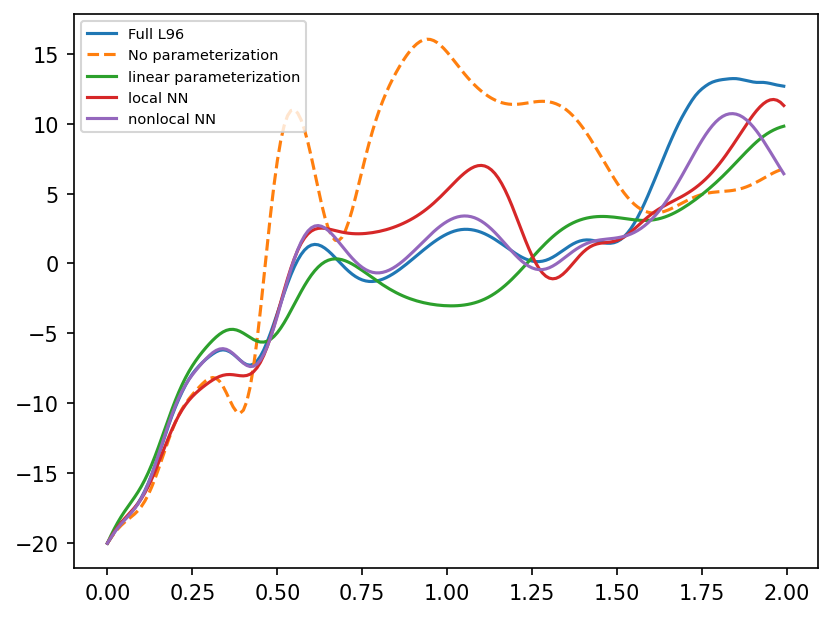

In [175]:
time_i = 200
plt.figure(dpi=150)
plt.plot(t[:time_i], X_full[:time_i, 4], label="Full L96")
plt.plot(t[:time_i], X_no_param[:time_i, 4], "--", label="No parameterization")

plt.plot(t[:time_i], Xnn_linear[:time_i, 4], label="linear parameterization")

plt.plot(t[:time_i], Xnn_local[:time_i, 4], label="local NN")
plt.plot(t[:time_i], Xnn_nonlocal[:time_i, 4], label="nonlocal NN")
plt.legend(loc="upper left", fontsize=7);

In [176]:
err_linear, err_local, err_nonlocal = [], [], []
T_test = 10

for i in range(90):
    init_conditions_i = X_full[i * 10, :]

    # Evaluate with linear network
    gcm_linear_net = GCM_network(forcing, linear_network)
    Xnn_linear, t = gcm_linear_net(
        init_conditions_i, dt, int(T_test / dt), linear_network
    )

    # Evaluate with local FCNN
    gcm_local_net = GCM_network(forcing, local_fcnn_network)
    Xnn_local, t = gcm_local_net(
        init_conditions_i, dt, int(T_test / dt), local_fcnn_network
    )

    # Evaluate with nonlocal FCNN
    gcm_nonlocal_net = GCM_network(forcing, nonlocal_fcnn_network)
    Xnn_nonlocal, t = gcm_nonlocal_net(
        init_conditions_i, dt, int(T_test / dt), nonlocal_fcnn_network
    )

    # GCM parameterized by the global 3-layer network
    # gcm_net_3layers = GCM_network(forcing, nn_3l)
    # Xnn_3layer_i, t = gcm_net_3layers(init_conditions_i, dt, int(T_test / dt), nn_3l)

    # GCM parameterized by the linear network
    # gcm_net_1layers = GCM_network(forcing, linear_network)
    # Xnn_1layer_i, t = gcm_net_1layers(init_conditions_i, dt, int(T_test / dt), linear_network)

"""
    err_linear.append(
        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_linear))
    )

    err_local.append(
        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_local))
    )

    err_nonlocal.append(
        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_nonlocal))
    )


print(f"Sum of errors for linear: {sum(err_linear):.2f}")
print(f"Sum of errors for local neural network: {sum(err_local):.2f}")
print(f"Sum of errors for non-local neural network: {sum(err_nonlocal):.2f}")
"""

'\n    err_linear.append(\n        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_linear))\n    )\n\n    err_local.append(\n        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_local))\n    )\n\n    err_nonlocal.append(\n        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_nonlocal))\n    )\n\n\nprint(f"Sum of errors for linear: {sum(err_linear):.2f}")\nprint(f"Sum of errors for local neural network: {sum(err_local):.2f}")\nprint(f"Sum of errors for non-local neural network: {sum(err_nonlocal):.2f}")\n'

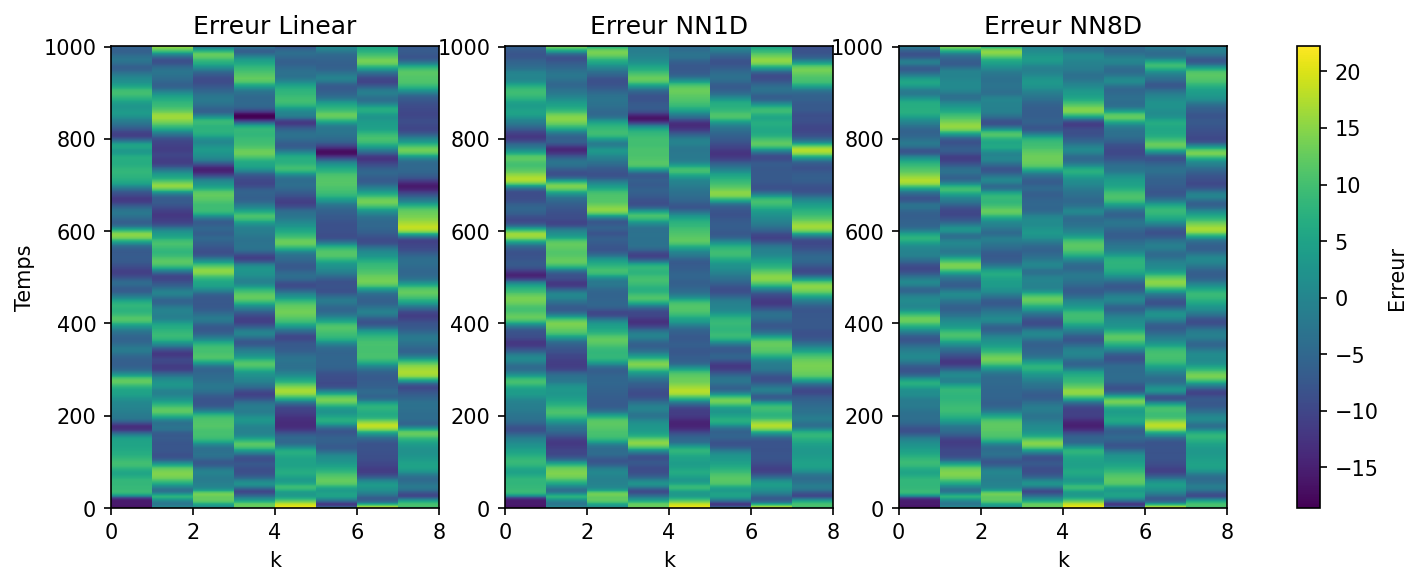

In [202]:
#Graphique 1 : hovmoller de l'erreur

err_linear_hov   = Xnn_linear - X_full
err_local_hov    = Xnn_local - X_full
err_nonlocal_hov = Xnn_nonlocal - X_full

#échelle de couleur
vmin = np.min([err_linear_hov.min(), err_local_hov.min(), err_nonlocal_hov.min()])
vmax = np.max([err_linear_hov.max(), err_local_hov.max(), err_nonlocal_hov.max()])

fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

im0 = ax[0].pcolormesh(err_linear_hov, shading='auto', vmin=vmin, vmax=vmax, cmap='viridis')
ax[0].set_title("Erreur Linear")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Temps")

im1 = ax[1].pcolormesh(err_local_hov, shading='auto', vmin=vmin, vmax=vmax, cmap='viridis')
ax[1].set_title("Erreur NN1D")
ax[1].set_xlabel("k")

im2 = ax[2].pcolormesh(err_nonlocal_hov, shading='auto', vmin=vmin, vmax=vmax, cmap='viridis')
ax[2].set_title("Erreur NN8D")
ax[2].set_xlabel("k")


fig.colorbar(im0, ax=ax.ravel().tolist(), label="Erreur")
plt.savefig("exp4_hovmoller.png", dpi=150)

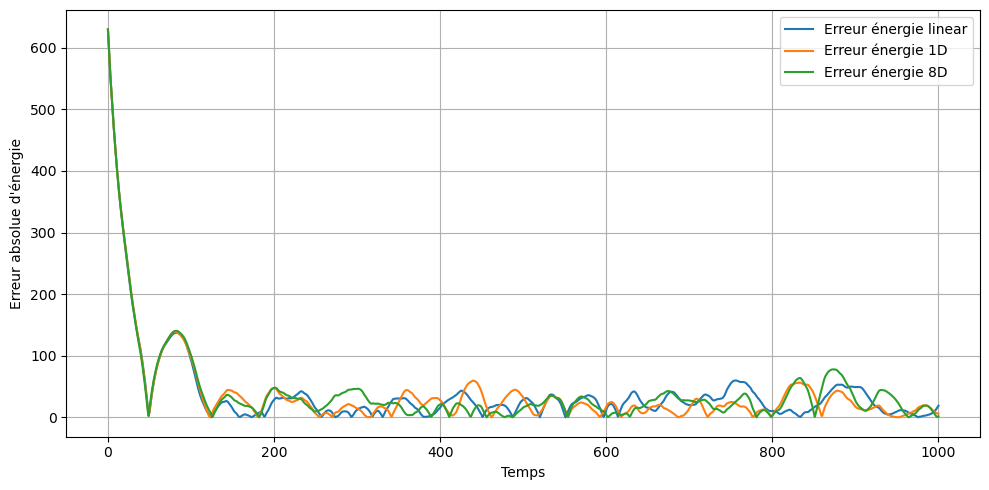

In [201]:
#Graphique 2 : erreur d'énergie

E_true = np.sum(X_full**2, axis=1)

E_linear = np.sum(Xnn_linear**2, axis=1)
E_local = np.sum(Xnn_local**2, axis=1)
E_nonlocal = np.sum(Xnn_nonlocal**2, axis=1)

# Erreurs d'énergie
err_E_linear = np.abs(E_linear - E_true)
err_E_local = np.abs(E_local - E_true)
err_E_nonlocal = np.abs(E_nonlocal - E_true)

time = np.arange(len(E_true))

plt.figure(figsize=(10,5))

plt.plot(time, err_E_linear, label="Erreur énergie linear")
plt.plot(time, err_E_local, label="Erreur énergie 1D")
plt.plot(time, err_E_nonlocal, label="Erreur énergie 8D")

plt.xlabel("Temps")
plt.ylabel("Erreur absolue d'énergie")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("exp4_energie.png", dpi=150)

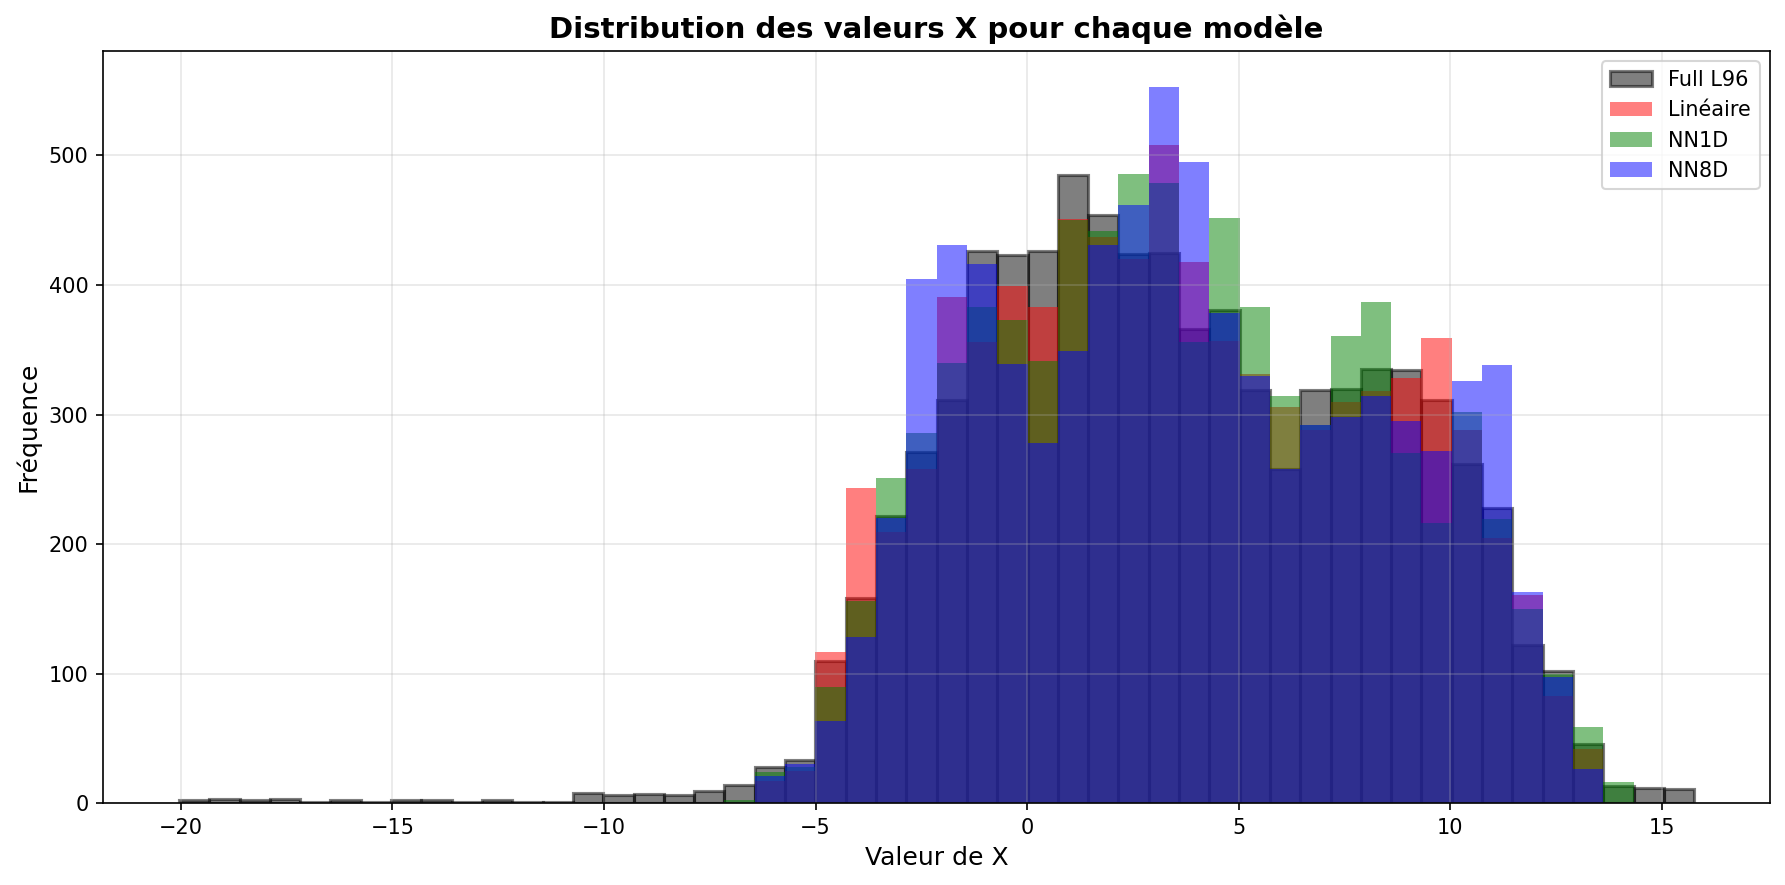

In [179]:

# Graphique 3 : Histogrammes superposés des distributions

plt.figure(figsize=(12, 6), dpi=150)

X_full_flat = X_full.flatten()
Xnn_linear_flat = Xnn_linear.flatten()
Xnn_local_flat = Xnn_local.flatten()
Xnn_nonlocal_flat = Xnn_nonlocal.flatten()

# limites
all_values = np.concatenate([X_full_flat, Xnn_linear_flat,
                              Xnn_local_flat, Xnn_nonlocal_flat])
vmin_global = all_values.min()
vmax_global = all_values.max()


# bins et histo
bins = np.linspace(vmin_global, vmax_global, 51)
alpha = 0.5

plt.hist(X_full_flat, bins=bins, alpha=alpha, label='Full L96',
         color='black', edgecolor='black', linewidth=1.5)
plt.hist(Xnn_linear_flat, bins=bins, alpha=alpha, label='Linéaire',
         color='red')
plt.hist(Xnn_local_flat, bins=bins, alpha=alpha, label='NN1D',
         color='green')
plt.hist(Xnn_nonlocal_flat, bins=bins, alpha=alpha, label='NN8D',
         color='blue')

plt.xlabel('Valeur de X', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.title('Distribution des valeurs X pour chaque modèle', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("histo_L96.png", dpi=300)


Linéaire:        E_clim = 6.4806
Local NN:        E_clim = 6.7263
Nonlocal NN:     E_clim = 5.3101
Linéaire:        E_dist = 0.1614
NN1D:        E_dist = 0.2570
NN8D:     E_dist = 0.2885


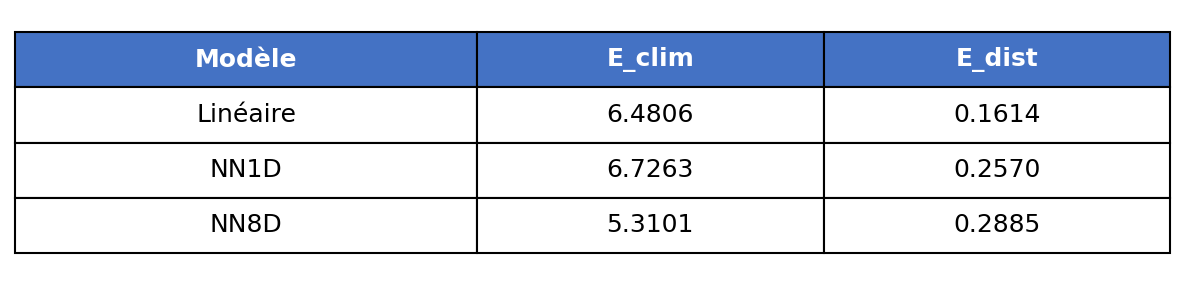

In [184]:
#Scores Eclim et Edist

#Eclim
E_clim_linear = np.abs(X_full_flat - Xnn_linear_flat).mean()
E_clim_local = np.abs(X_full_flat - Xnn_local_flat).mean()
E_clim_nonlocal = np.abs(X_full_flat - Xnn_nonlocal_flat).mean()

#Edist
def compute_cdf_distance(x_true, x_model, bins):
    """Calcule la distance entre deux CDFs empiriques"""
    # Compter les valeurs dans chaque bin
    hist_true, _ = np.histogram(x_true, bins=bins, density=True)
    hist_model, _ = np.histogram(x_model, bins=bins, density=True)

    # Convertir en CDF (fonction de distribution cumulative)
    bin_width = bins[1] - bins[0]
    cdf_true = np.cumsum(hist_true) * bin_width
    cdf_model = np.cumsum(hist_model) * bin_width

    E_dist = np.sum(np.abs(cdf_true - cdf_model)) * bin_width

    return E_dist

E_dist_linear = compute_cdf_distance(X_full_flat, Xnn_linear_flat, bins)
E_dist_local = compute_cdf_distance(X_full_flat, Xnn_local_flat, bins)
E_dist_nonlocal = compute_cdf_distance(X_full_flat, Xnn_nonlocal_flat, bins)

# tableau
fig, ax = plt.subplots(figsize=(8, 2), dpi=150)
ax.axis('tight')
ax.axis('off')

models = ['Linéaire', 'NN1D', 'NN8D']
E_atm_values = [E_clim_linear, E_clim_local, E_clim_nonlocal]
E_dist_values = [E_dist_linear, E_dist_local, E_dist_nonlocal]

table_data = []
for i, model in enumerate(models):
    table_data.append([model, f'{E_atm_values[i]:.4f}', f'{E_dist_values[i]:.4f}'])

table = ax.table(cellText=table_data,
                colLabels=['Modèle', 'E_clim', 'E_dist'],
                cellLoc='center',
                loc='center',
                colWidths=[0.4, 0.3, 0.3])

for i in range(len(table_data)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

plt.tight_layout()
plt.savefig("table_metrique.png", dpi=300)

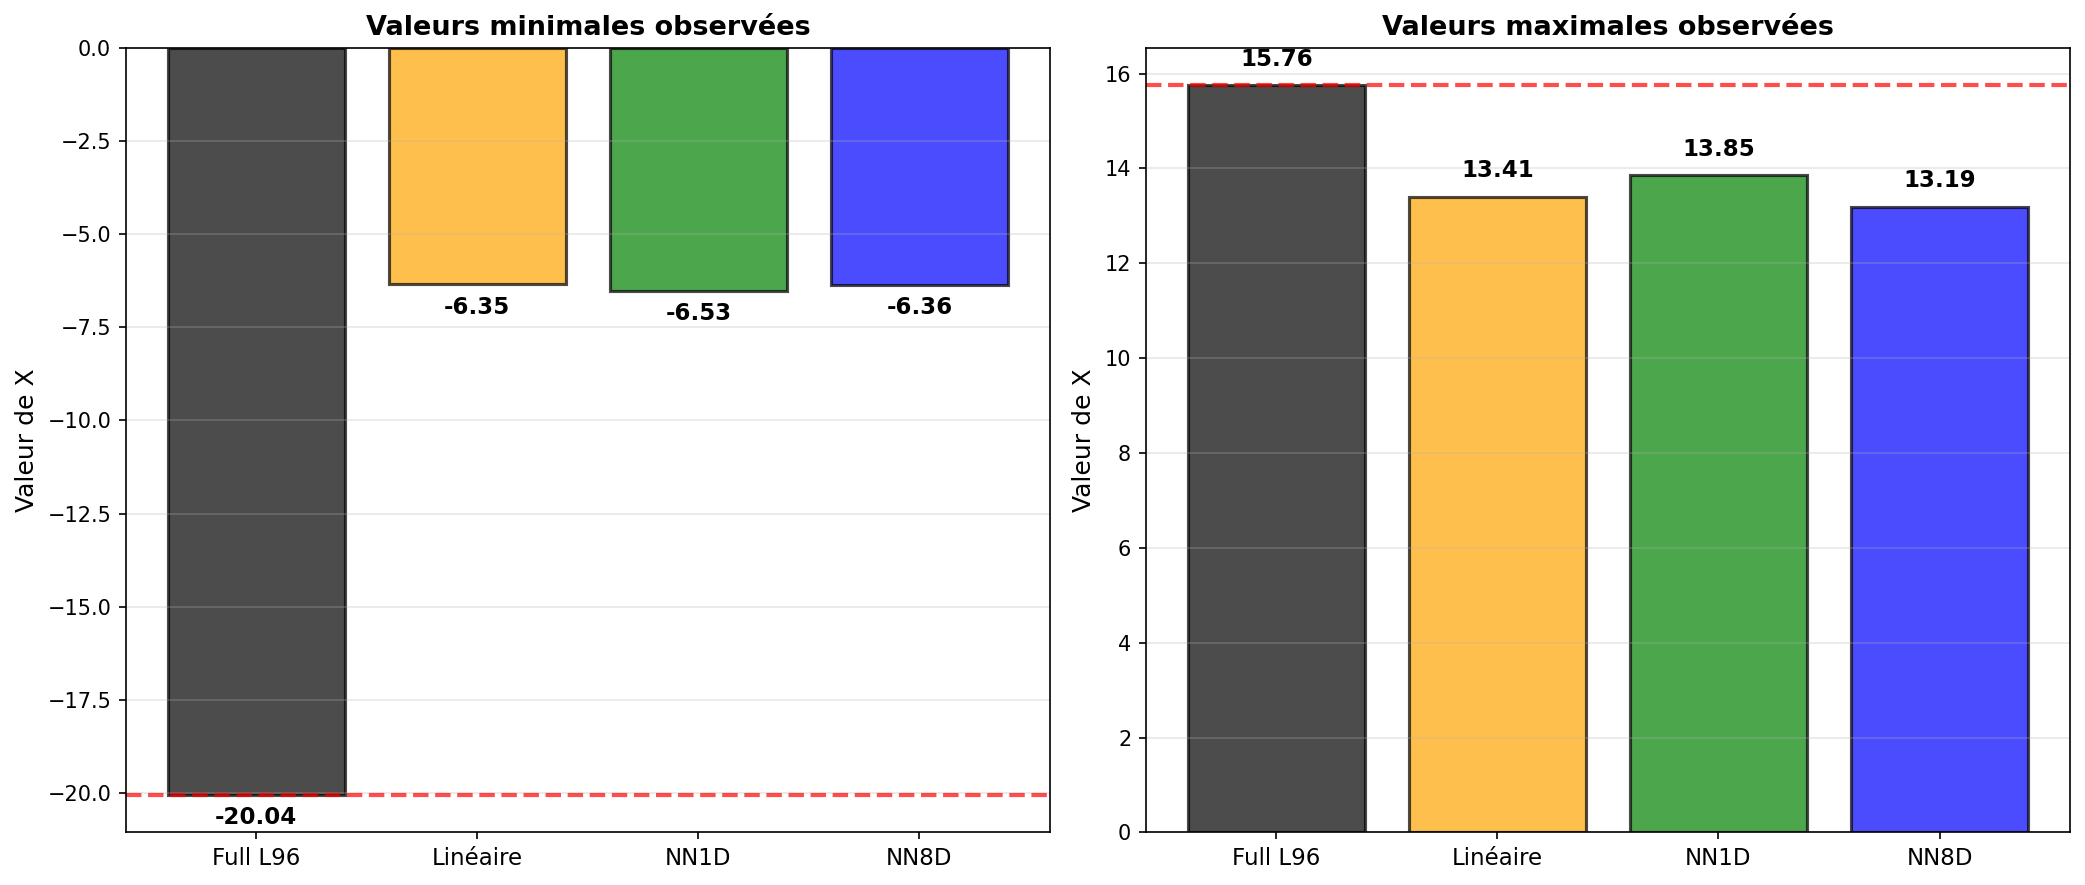

In [205]:
# Graphique : Analyse des valeurs extrêmes (Maximum et Minimum)

# Calculer les statistiques extrêmes pour chaque modèle
X_full_flat = X_full.flatten()
Xnn_linear_flat = Xnn_linear.flatten()
Xnn_local_flat = Xnn_local.flatten()
Xnn_nonlocal_flat = Xnn_nonlocal.flatten()

# Statistiques globales
stats_data = {
    'Full L96': {
        'min': X_full_flat.min(),
        'max': X_full_flat.max(),

    },
    'Linéaire': {
        'min': Xnn_linear_flat.min(),
        'max': Xnn_linear_flat.max(),

    },
    'NN1D': {
        'min': Xnn_local_flat.min(),
        'max': Xnn_local_flat.max(),

    },
    'NN8D': {
        'min': Xnn_nonlocal_flat.min(),
        'max': Xnn_nonlocal_flat.max(),

    }
}

# min/max
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

models = ['Full L96', 'Linéaire', 'NN1D', 'NN8D']
colors = ['black', 'orange', 'green', 'blue']
x_pos = np.arange(len(models))

#min
mins = [stats_data[m]['min'] for m in models]
axes[0].bar(x_pos, mins, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axhline(y=stats_data['Full L96']['min'], color='red', linestyle='--',
                linewidth=2, alpha=0.7, label='Référence (Full L96)')

for i, (pos, val) in enumerate(zip(x_pos, mins)):
    axes[0].text(pos, val - 0.3, f'{val:.2f}', ha='center', va='top',
                fontsize=11, fontweight='bold')

axes[0].set_ylabel('Valeur de X', fontsize=12)
axes[0].set_title('Valeurs minimales observées', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Max
maxs = [stats_data[m]['max'] for m in models]
axes[1].bar(x_pos, maxs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axhline(y=stats_data['Full L96']['max'], color='red', linestyle='--',
                linewidth=2, alpha=0.7, label='Référence (Full L96)')

for i, (pos, val) in enumerate(zip(x_pos, maxs)):
    axes[1].text(pos, val + 0.3, f'{val:.2f}', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

axes[1].set_ylabel('Valeur de X', fontsize=12)
axes[1].set_title('Valeurs maximales observées', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models, fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('exp4_maxmin.png', dpi=150)